In [2]:
from scipy import io, signal
import matplotlib.pyplot as plt
import dtcwt
import numpy as np
import itertools
import pywt

### DTCWT Sub-band Selection

In [3]:
# Load DWT-denoised time-series data
SubA = io.loadmat('DWT_A.mat')
SubC = io.loadmat('DWT_C.mat')
A_sig = SubA['DWT_A']
A_lab = SubA['A_LAB']
C_sig = SubC['DWT_C']
C_lab = SubC['C_LAB']
print(A_sig.shape)
print(A_lab.shape)
print(C_sig.shape)
print(C_lab.shape)

(5, 1024, 270)
(270, 1)
(5, 1024, 180)
(180, 1)


In [4]:
# Mixing two subjects' data
SubX_sig = np.concatenate((A_sig, C_sig), axis=-1)
print(SubX_sig.shape)
SubX_lab = np.concatenate((A_lab, C_lab), axis=0)
print(SubX_lab.shape)

(5, 1024, 450)
(450, 1)


In [20]:
# all g.tech [2-30], B - Neuroscan [0.1-100]
# So, 3 level DTCWT
# Lower complexity for feature extraction
# Cite DTCWT?

In [5]:
n_ch, tp, sp = SubX_sig.shape
A_sig_dtcwt = np.zeros((sp,(int)(tp/8),n_ch), dtype=np.float32)
transform = dtcwt.Transform1d()
for cs in range(sp):
    for ch in range(n_ch):
        vecs_t = transform.forward(SubX_sig[ch,:,cs], nlevels=3)
        A_sig_dtcwt[cs,:,ch] = np.abs(vecs_t.highpasses[2]).reshape(int(tp/8))
        # Took absoulute value
        # May change
print(A_sig_dtcwt.shape)

(450, 128, 5)


In [64]:
print(len(vecs_t.highpasses[0]))
print(len(vecs_t.highpasses[1]))
print(len(vecs_t.highpasses[2]))

512
256
128


In [67]:
dtcwt_lev1 = np.abs(vecs_t.highpasses[0])
dtcwt_lev2 = np.abs(np.repeat(vecs_t.highpasses[1],2))
dtcwt_lev3 = np.abs(np.repeat(vecs_t.highpasses[2],4))
print(len(dtcwt_lev1))
print(len(dtcwt_lev2))
print(len(dtcwt_lev3))

512
512
512


In [73]:
dtcwt_lev = np.zeros((3,512), dtype=np.float32)
dtcwt_lev[0] = dtcwt_lev1.reshape(512)
dtcwt_lev[1] = dtcwt_lev2.reshape(512)
dtcwt_lev[2] = dtcwt_lev3.reshape(512)
print(dtcwt_lev.shape)

(3, 512)


In [74]:
io.savemat('dtcwt_lev.mat', {'dtcwt_lev': dtcwt_lev})

In [22]:
# A_sig_dtcwt = A_sig # features taken from denoised signal

### Feature Extraction

In [6]:
import pandas as pd
from numpy.linalg import LinAlgError
from statsmodels.tsa.stattools import adfuller
#1
def AE(x): # Absolute Energy
    x = np.asarray(x)
    return sum(x * x)

#2
def SM2(y):
    #t1 = time.time()
    f, Pxx_den = signal.welch(y)
    sm2 = 0
    n = len(f)
    for i in range(0,n):
        sm2 += Pxx_den[i]*(f[i]**2)
    
    #t2 = time.time()
    #print('time: ', t2-t2)
    return sm2


#3
def LOG(y):
    n = len(y)
    return np.exp(np.sum(np.log(np.abs(y)))/n)

#4
def WL(x): # WL in primary manuscript
    return np.sum(abs(np.diff(x)))

#5
def ADF(x): # teststat, pvalue, usedlag
    # augmented dickey fuller
    # returns a tuple
    res = None
    try:
        res = adfuller(x)
    except LinAlgError:
        res = np.NaN, np.NaN, np.NaN
    except ValueError:  # occurs if sample size is too small
        #print('Length Error')
        res = np.NaN, np.NaN, np.NaN

    return res[0], res[1], res[2]


#6
def AC(x, lag=5): # autocorrelation

    """
     [1] https://en.wikipedia.org/wiki/Autocorrelation#Estimation

    """
    # This is important: If a series is passed, the product below is calculated
    # based on the index, which corresponds to squaring the series.
    if type(x) is pd.Series:
        x = x.values
    if len(x) < lag:
        return np.nan
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x
    x_mean = np.mean(x)
    # The result is sometimes referred to as "covariation"
    sum_product = np.sum((y1-x_mean)*(y2-x_mean))
    # Return the normalized unbiased covariance
    return sum_product / ((len(x) - lag) * np.var(x))

#7
def BE(x, max_bins=30): # binned entropy
    hist, bin_edges = np.histogram(x, bins=max_bins)
    probs = hist / len(x)
    return - np.sum(p * np.math.log(p) for p in probs if p != 0)

#8
def C3(x, lag = 5): # c3 feature
    n = len(x)
    x = np.asarray(x)
    if 2 * lag >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -lag) * np.roll(x, -lag) * x)[0:(n - 2 * lag)])
    
    
#9
def CC(x, normalize=True): # cid ce
    x = np.asarray(x)
    if normalize:
        s = np.std(x)
        if s!=0:
            x = (x - np.mean(x))/s
        else:
            return 0.0

    x = np.diff(x)
    return np.sqrt(np.sum((x * x)))


#10
def CAM(x): # count above mean
    x = np.asarray(x)
    m = np.mean(x)
    return np.where(x > m)[0].shape[0]

#11
def CBM(x): # count below mean
    x = np.asarray(x)
    m = np.mean(x)
    return np.where(x < m)[0].shape[0]


#12
def AAC(x): #AAC in primary manuscript
    return np.mean(abs(np.diff(x)))

#13
def MSDC(x): # mean second derivative central
    diff = (np.roll(x, 1) - 2 * np.array(x) + np.roll(x, -1)) / 2.0
    return np.mean(diff[1:-1])

#14
def ZC(x, m = 0): # zero/mean crossing
    # m = np.mean(x)
    x = np.asarray(x)
    x = x[x != m]
    return sum(np.abs(np.diff(np.sign(x - m))))/2


#15
def SE(x): # sample entropy
    """
    [1] http://en.wikipedia.org/wiki/Sample_Entropy
    [2] https://www.ncbi.nlm.nih.gov/pubmed/10843903?dopt=Abstract
    """
    x = np.array(x)

    sample_length = 1 # number of sequential points of the time series
    tolerance = 0.2 * np.std(x) # 0.2 is a common value for r - why?

    n = len(x)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((1, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((1, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = x[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[0]))

    # sample entropy = -1 * (log (A/B))
    similarity_ratio = A / B
    se = -1 * np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se[0]

#16
def TRAS(x, lag=5):
    # time reversal asymmetry statistic
    """
    |  [1] Fulcher, B.D., Jones, N.S. (2014).
    |  Highly comparative feature-based time-series classification.
    |  Knowledge and Data Engineering, IEEE Transactions on 26, 3026–3037.
    """
    n = len(x)
    x = np.asarray(x)
    if 2 * lag >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -lag) * np.roll(x, 2 * -lag) * np.roll(x, -lag) -
                        np.roll(x, -lag) * x * x)[0:(n - 2 * lag)])
    
    
#17    
def VAR(x): # variance 
    return np.var(x)

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [139]:
# excluded wavelet entropy, skewness, kurtosis, perm. entropy, multiscale entropy
# not enough variance, NaN

In [7]:
n_features = 17
n_features += 2 # ADF
featuresAll = np.zeros((sp,n_ch*n_features), dtype = np.float32)
import time
t1 = time.time()
# To-do: Optimize {PyPy didn't help}
for cs in range(sp):
    c_f = []
    for ch in range(n_ch):
        y = A_sig_dtcwt[cs,:,ch]
        c_f.append(AE(y))
        c_f.append(SM2(y))
        c_f.append(LOG(y))
        c_f.append(WL(y))
        f1, f2, f3 = ADF(y)
        c_f.append(f1)
        c_f.append(f2)
        c_f.append(f3)
        c_f.append(AC(y))
        c_f.append(BE(y))
        c_f.append(C3(y))
        c_f.append(CC(y))
        c_f.append(CAM(y))
        c_f.append(CBM(y))
        c_f.append(AAC(y))
        c_f.append(MSDC(y))
        c_f.append(ZC(y))
        c_f.append(SE(y))
        c_f.append(TRAS(y))
        c_f.append(VAR(y))
    #c_f = np.array(c_f)
    #c_f = c_f.reshape(n_ch*n_features)
    featuresAll[cs,:] = c_f  
    print(cs,end = '.')

t2 = time.time()
print('\ntime: ',t2-t1,'s')

C:\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

In [10]:
featuresAll.shape

(450, 95)

### Feature Selection

In [9]:
def feature_name(id_):
    #cid = id-1
    channel = (id_//19) + 1
    fid = id_%19
    feat_nam = ['AE', 'SM2', 'LOG', 'WL', 'ADF I', 
               'ADF II', 'ADF III', 'AC', 'BE', 'C3',
               'CC', 'CAM', 'CBM', 'AAC', 'MSDC', 'ZC', 'SE',
               'TRAS', 'VAR']
    return str(feat_nam[fid] + ' [%s]'%str(channel))

In [12]:
X_all = featuresAll
y = SubX_lab.reshape(len(SubX_lab),)
print(np.mean(X_all))
print(np.var(X_all))

7.4996915
398.1879


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_all)
print(scaler.mean_)
X_all = scaler.transform(X_all)

print(np.mean(X_all))
print(np.std(X_all))

[ 1.1004589e-09  1.2669177e-11  1.5317845e-06  1.5746578e-04
 -4.3901339e+00  3.3335622e-02  3.6044445e+00  6.9551907e-02
  2.9327700e+00  1.6360645e-17  1.0827678e+01  5.3311111e+01
  7.4688889e+01  1.2398881e-06 -1.3684596e-09  0.0000000e+00
  1.9884915e+00 -1.4918126e-18  3.3235706e-12  5.6031702e-10
  6.4939846e-12  1.0894241e-06  1.0898085e-04 -4.7382946e+00
  1.9407958e-02  3.4911110e+00  3.3362493e-02  2.9190478e+00
  5.6624467e-18  1.0649881e+01  5.3157776e+01  7.4842224e+01
  8.5811689e-07 -3.7070602e-10  0.0000000e+00  1.9782687e+00
 -1.9287489e-19  1.7318892e-12  6.8999562e-10  7.6177797e-12
  1.0815531e-06  1.0974071e-04 -4.5805202e+00  1.9122403e-02
  3.6355555e+00  1.6382523e-02  2.9286633e+00  7.9856463e-18
  1.0704454e+01  5.3091110e+01  7.4908890e+01  8.6410103e-07
 -5.0707483e-10  0.0000000e+00  1.9844669e+00 -2.8502568e-18
  2.3721866e-12  4.7287657e-10  4.5675352e-12  9.8957923e-07
  9.5172079e-05 -4.6801443e+00  1.6372900e-02  3.3133333e+00
  3.0616071e-02  2.91109

* Univariate feature selection

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
print(X_all.shape)
X_fs_o = SelectKBest(mutual_info_classif, k=30)
X_fs = X_fs_o.fit_transform(X_all, y)
feature_ids = X_fs_o.get_support(indices=True)

mi = mutual_info_classif(X_fs,y)

print(X_fs.shape)

(450, 95)
(450, 30)


C:\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [16]:
print(X_fs.shape)
print(y.shape)

(450, 30)
(450,)


In [75]:
np.save('features_AC.npy',X_fs)
np.save('y_response.npy',y)

In [17]:
print('Mutual Information')
features_sl = []
for i in range(len(feature_ids)):
    features_sl.append(feature_name(feature_ids[i]))
    print(features_sl[i],': ',mi[i])

Mutual Information
AE [1] :  0.31582225494351723
SM2 [1] :  0.35705347256677666
LOG [1] :  0.2778698681767624
WL [1] :  0.33044142790732245
C3 [1] :  0.3381129040609807
AAC [1] :  0.33044142790732245
VAR [1] :  0.31180619856046166
AE [2] :  0.16104564518307019
C3 [2] :  0.14738952501479674
AE [3] :  0.20542499261622615
SM2 [3] :  0.21040578192329074
LOG [3] :  0.21698919033126662
WL [3] :  0.24841595417786522
C3 [3] :  0.23630282027795801
AAC [3] :  0.24841595417786522
VAR [3] :  0.1494534721521985
AE [4] :  0.1817786134749413
SM2 [4] :  0.2236372260832804
LOG [4] :  0.1553048623129447
WL [4] :  0.2112459876146109
C3 [4] :  0.14077175042927492
AAC [4] :  0.2112459876146109
VAR [4] :  0.16997441930221235
AE [5] :  0.2045245024934621
SM2 [5] :  0.17361973248554619
LOG [5] :  0.1582081153953312
WL [5] :  0.19185799806220238
C3 [5] :  0.18004597521489218
AAC [5] :  0.19185799806220238
VAR [5] :  0.16237023656816296


* Feature importnace

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature ranking:
1. Feature SM2 [1] (0.075196)
2. Feature WL [1] (0.066286)
3. Feature AAC [1] (0.058747)
4. Feature C3 [1] (0.054356)
5. Feature LOG [1] (0.053231)
6. Feature AAC [3] (0.048648)
7. Feature WL [3] (0.046738)
8. Feature SM2 [3] (0.042235)
9. Feature AE [1] (0.039565)
10. Feature VAR [1] (0.038063)
11. Feature AAC [5] (0.031836)
12. Feature LOG [5] (0.030498)
13. Feature AAC [4] (0.028939)
14. Feature WL [4] (0.028815)
15. Feature LOG [3] (0.028376)
16. Feature WL [5] (0.028200)
17. Feature C3 [5] (0.027912)
18. Feature AE [5] (0.027744)
19. Feature SM2 [5] (0.025456)
20. Feature SM2 [4] (0.025244)
21. Feature LOG [4] (0.024864)
22. Feature AE [3] (0.023810)
23. Feature C3 [3] (0.021413)
24. Feature VAR [5] (0.020410)
25. Feature VAR [3] (0.019478)
26. Feature C3 [2] (0.018154)
27. Feature AE [2] (0.017457)
28. Feature AE [4] (0.016973)
29. Feature C3 [4] (0.016952)
30. Feature VAR [4] (0.014404)


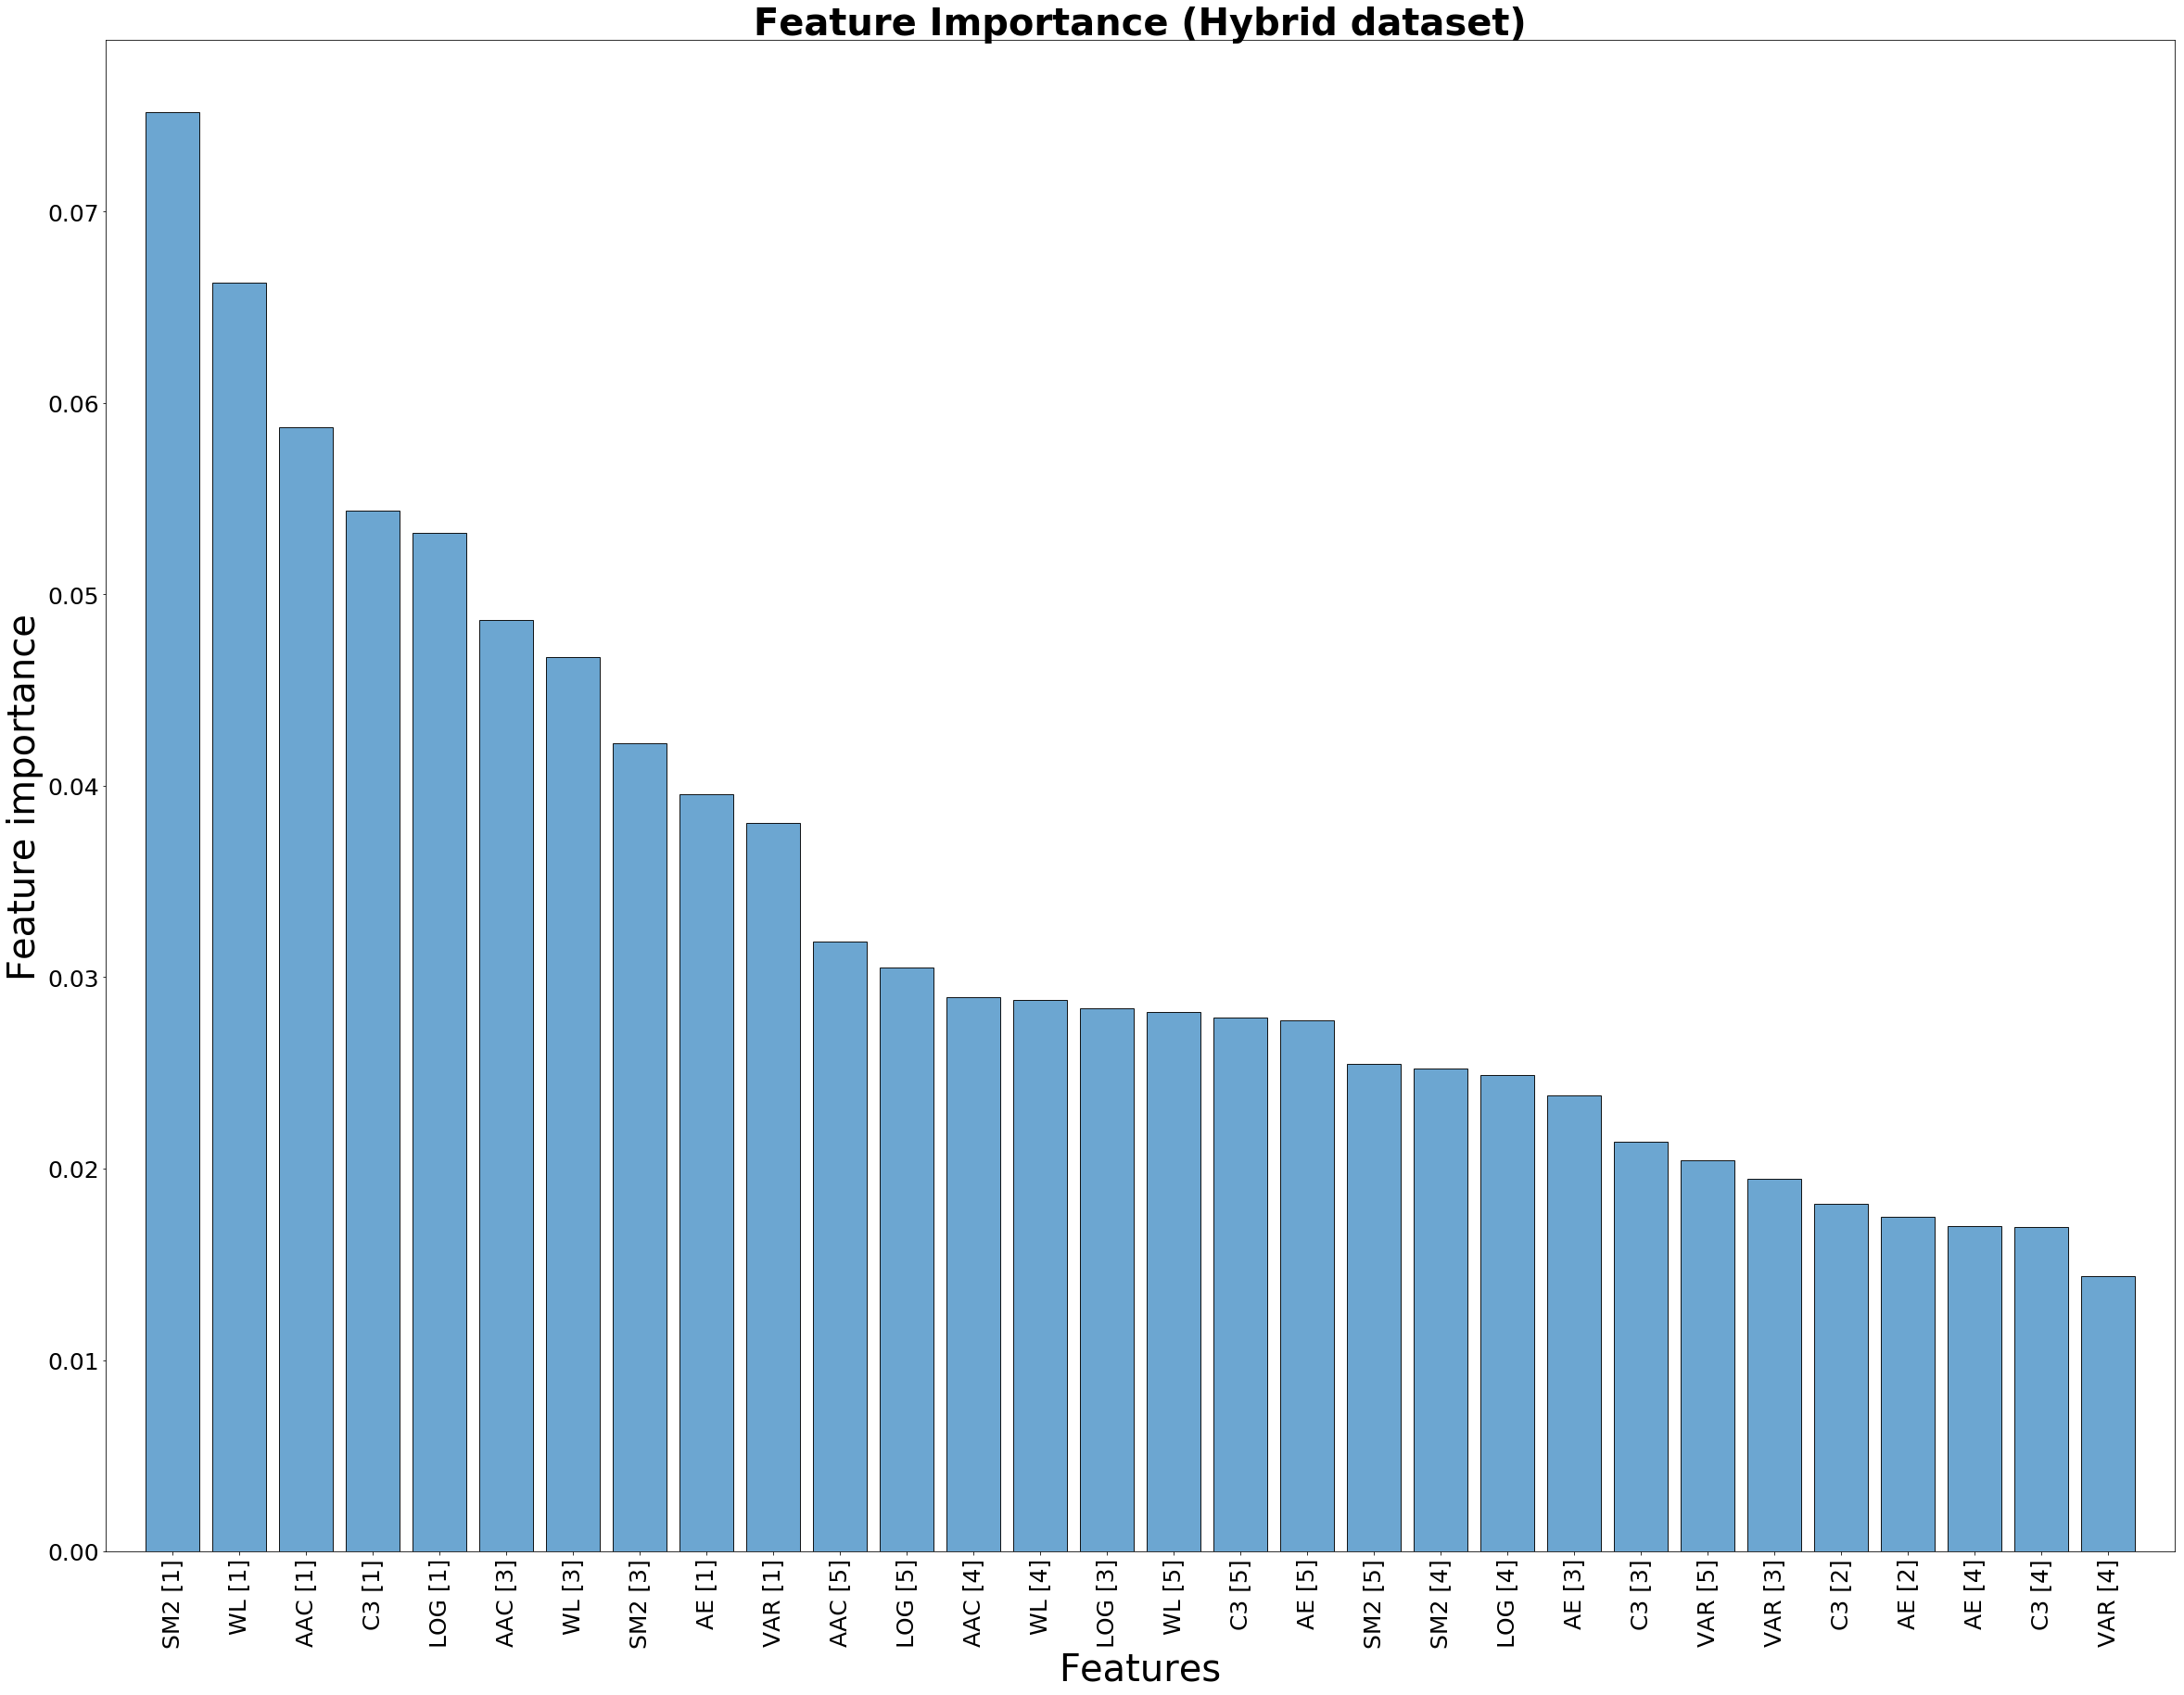

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X = X_fs
y = SubX_lab

# Build a forest from extra trees and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Feature ranking according to forest classifier
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. Feature %s (%f)" % ( (f + 1), features_sl[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(40,30))

B_SIZE = 30
axis_font = {'fontname':'Arial', 'size':'30'}
plt.rc('font', size=B_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=B_SIZE+10)     # fontsize of the axes title
plt.rc('axes', labelsize=B_SIZE+10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=B_SIZE-5)    # fontsize of the tick labels
plt.rc('ytick', labelsize=B_SIZE-5)    # fontsize of the tick labels
plt.rc('legend', fontsize=B_SIZE)    # legend fontsize
plt.rc('figure', titlesize=B_SIZE)  # fontsize of the figure title
#plt.rc('xlabel', titlesize=B_SIZE+10)
#plt.rc('ylabel', titlesize=B_SIZE+10)

plt.title("Feature Importance (Hybrid dataset)", fontweight='bold')
plt.bar(range(X.shape[1]), importances[indices],
       color='#5c9dcc', align="center",
       alpha=0.9, edgecolor='k') #  yerr=std[indices]
plt.xticks(range(X.shape[1]), [features_sl[i] for i in indices], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.xlim([-1, X.shape[1]])
plt.savefig('bar_plot_feature_importance.png', bbox_inches='tight')
plt.show()  

In [56]:
# Used a small subset [single subject] of the dataset to select fetures
# Used a model, which was not used in the validation
# Later k-fold CV

In [57]:
# Important features 
# All other features are removed
# All channels are kept

In [58]:
#A_sig_dtcwt = np.moveaxis(A_sig_dtcwt,-1,1)
#print(A_sig_dtcwt.shape)

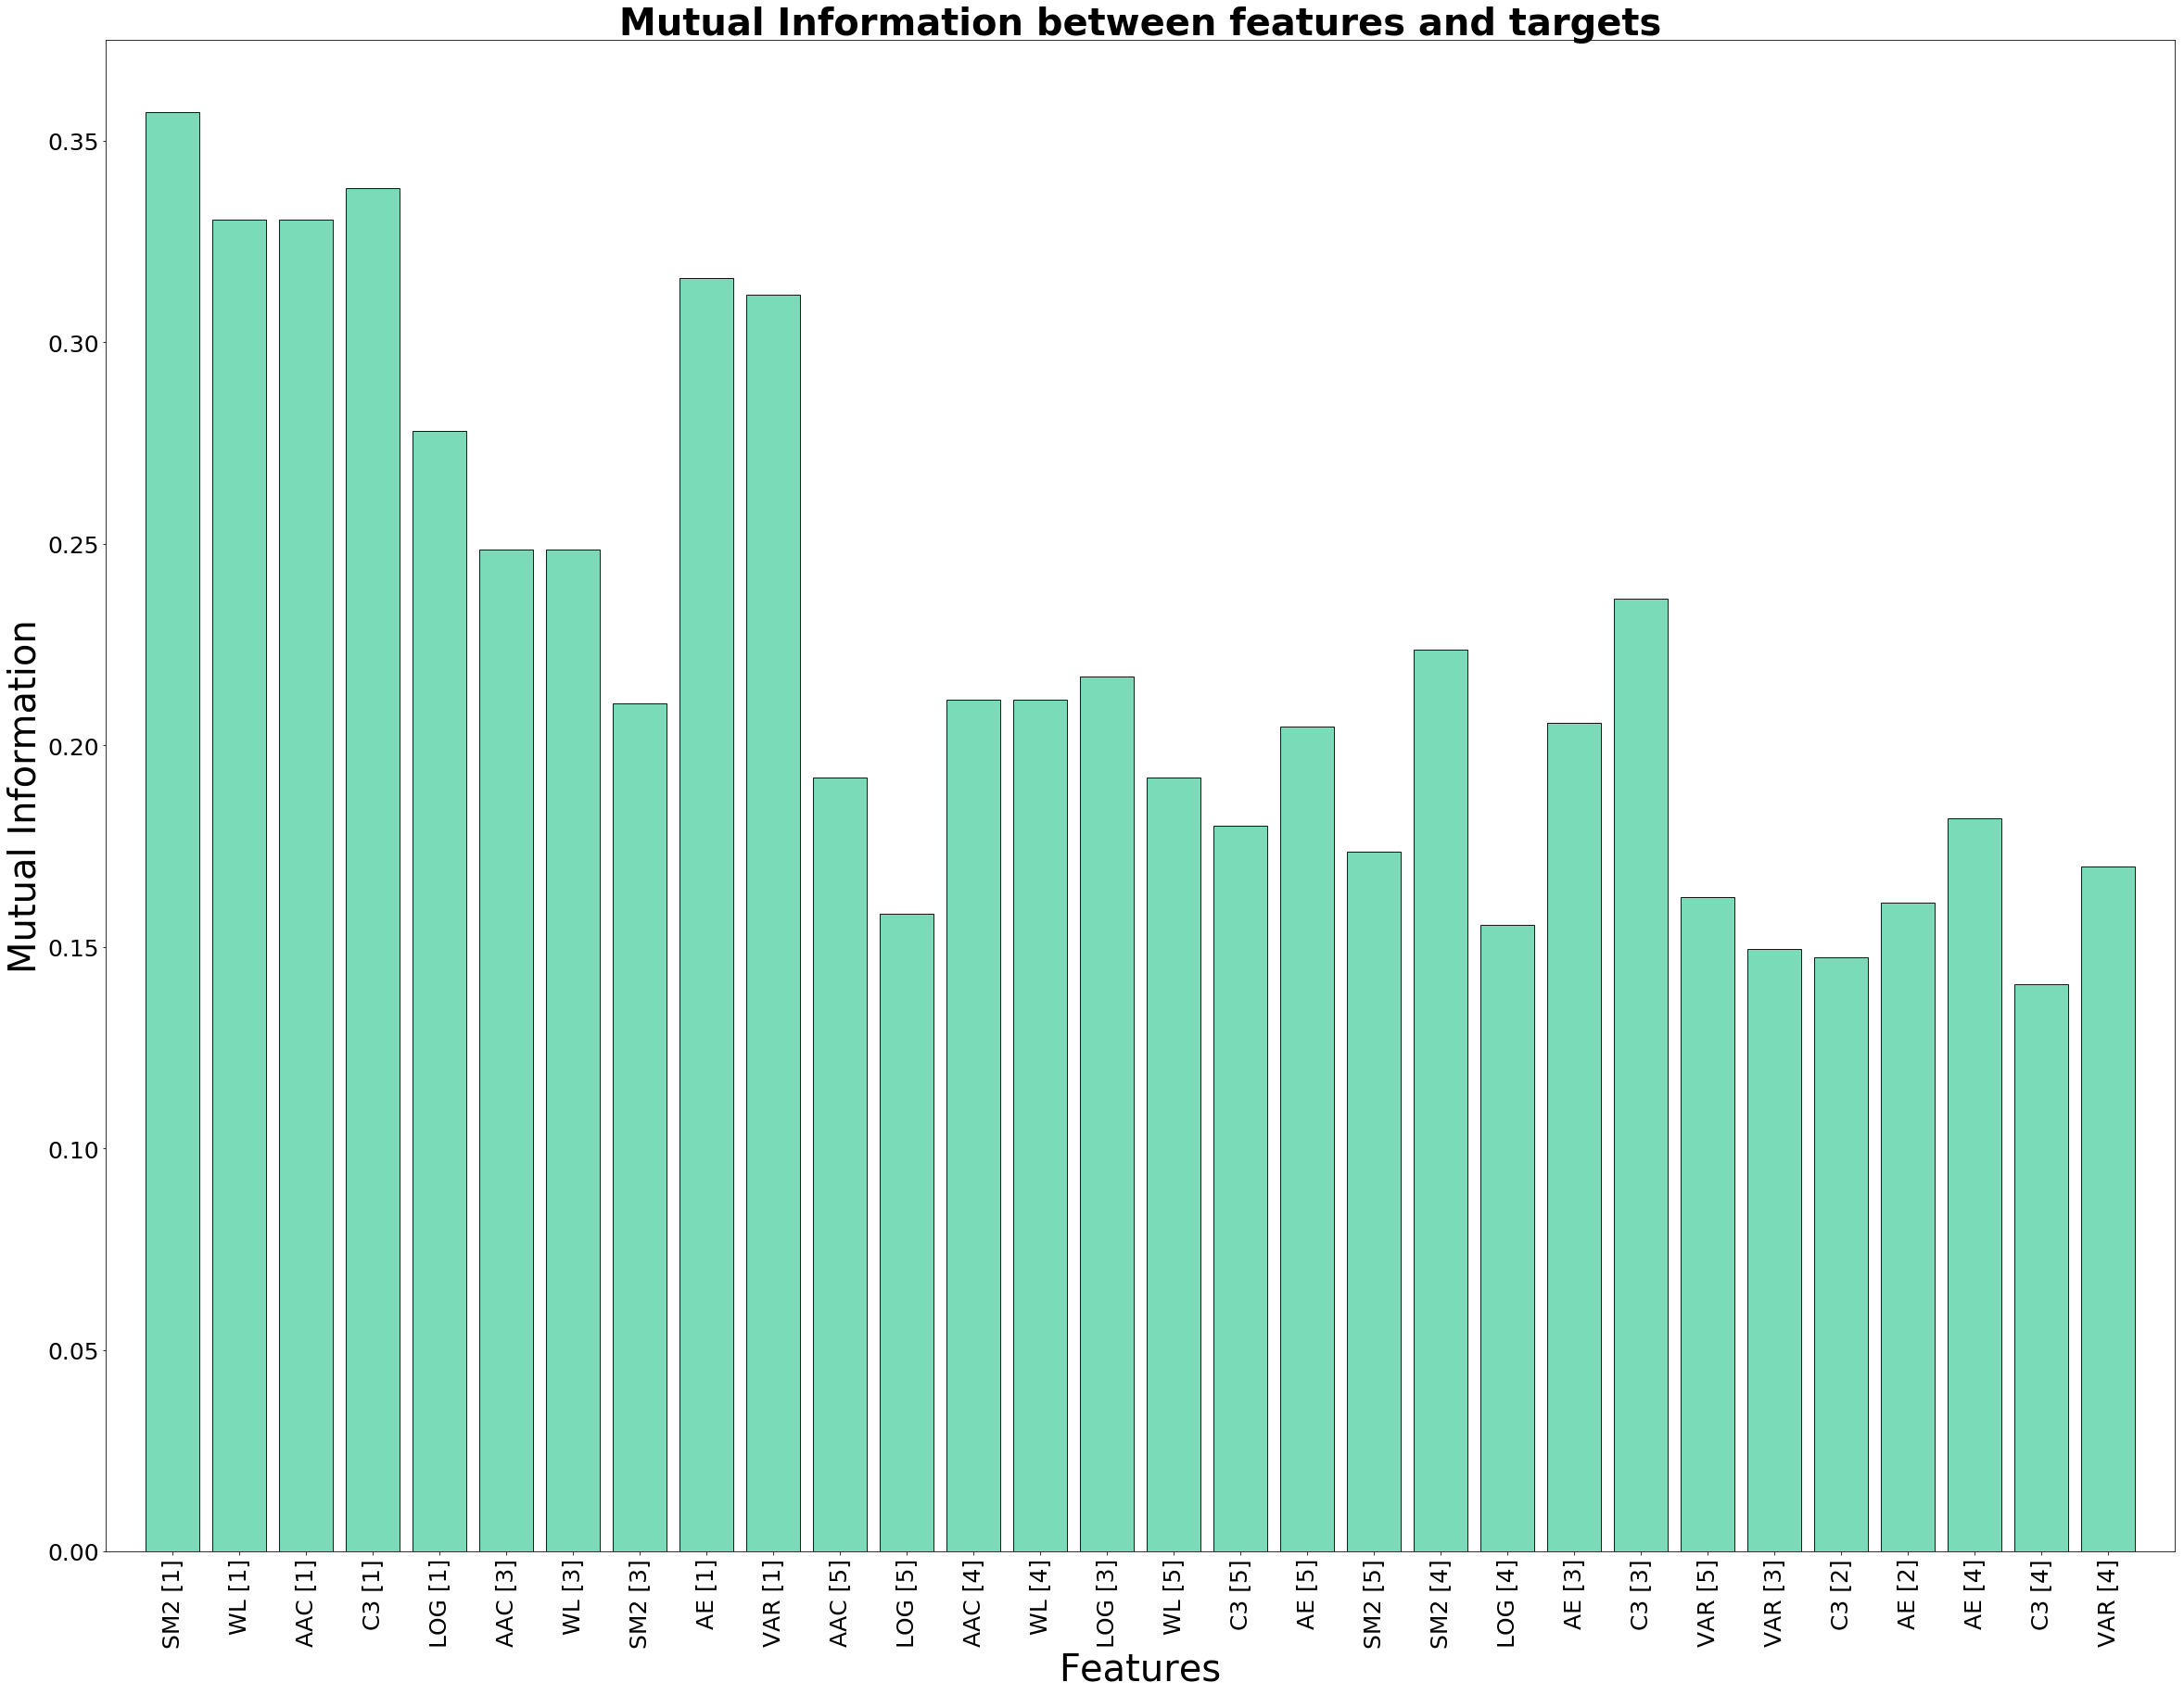

In [24]:
# Plot the feature importances of the forest
plt.figure(figsize=(40,30))

B_SIZE = 30
axis_font = {'fontname':'Arial', 'size':'30'}
plt.rc('font', size=B_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=B_SIZE+10)     # fontsize of the axes title
plt.rc('axes', labelsize=B_SIZE+10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=B_SIZE-5)    # fontsize of the tick labels
plt.rc('ytick', labelsize=B_SIZE-5)    # fontsize of the tick labels
plt.rc('legend', fontsize=B_SIZE)    # legend fontsize
plt.rc('figure', titlesize=B_SIZE)  # fontsize of the figure title
#plt.rc('xlabel', titlesize=B_SIZE+10)
#plt.rc('ylabel', titlesize=B_SIZE+10)

plt.title("Mutual Information between features and targets", fontweight='bold')
plt.bar(range(X.shape[1]), mi[indices],
       color='#6cd7b2', align="center",
       alpha=0.9, edgecolor='k') #  yerr=std[indices]
plt.xticks(range(X.shape[1]), [features_sl[i] for i in indices], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.xlim([-1, X.shape[1]])
plt.savefig('bar_plot_MI.png', bbox_inches='tight')
plt.show() 

### Classification with all selected features

In [48]:
X = X_fs
y = SubX_lab
y = y.reshape(len(y),)
print(y.shape)

(450,)


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(X))

print(scaler.mean_)

print(scaler.transform(X))

X = scaler.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)
[ 2.71267368e-07 -1.18679473e-07  8.81618917e-07  4.49286574e-07
  1.27156582e-07  3.05175774e-07 -2.11927631e-08  3.39084210e-07
  3.39084210e-08 -1.61064989e-07 -7.62939436e-08 -1.25461156e-06
  4.91672097e-07 -1.56826445e-07 -1.54283316e-06  2.49014960e-08
  9.96059839e-08 -6.90884065e-07 -3.13652890e-07  4.83194981e-07
  2.88221571e-07 -1.57674151e-06 -1.90734859e-08  1.35633684e-07
  1.78019206e-07 -4.74717893e-07  1.69542105e-07 -8.47710524e-09
  1.01725263e-07  1.05963814e-07]
[[-4.1468090e-01 -8.4674144e-01 -7.7635181e-01 ... -1.7314297e-01
  -5.5068231e-01 -1.5885355e-01]
 [-2.5301713e-02 -1.5641887e-01  5.8571202e-01 ... -1.9133644e-01
  -5.7329065e-01 -1.8553351e-01]
 [-2.1612310e-01 -4.5085651e-01 -1.2959120e-01 ... -1.9970101e-01
  -6.7207938e-01 -1.9145812e-01]
 ...
 [ 5.6242192e-01  5.0433081e-01  1.6153896e+00 ...  9.4587412e-03
   7.5359261e-01  3.1665224e-04]
 [-4.0247354e-01 -8.5722470e-01 -1.0664951e+00 ...  1

In [50]:
print(X.shape)
print(np.max(X))
print(np.min(X))
print(np.mean(X))
print(np.var(X))

(450, 30)
20.900858
-1.9009194
-4.2385526e-10
1.0


In [152]:
# 10-fold cross validation

In [19]:
# SubA - DTCWT, 1 level, high, abs, Accuracy:  0.5444444444444445,0.28118893179410825
# SubA - DTCWT, 2 level, high, abs, Accuracy:  0.8037037037037038 0.11011902775791484
# SubA - DTCWT, 3 level, high, abs, Accuracy:  0.774074074074074,0.1343582010904967
# SubA - DWT denoised - Accuracy:  0.711111111111111 0.1274418558080389

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: ', scores.mean(), scores.std() * 2)                                             

Accuracy:  0.8177777777777777 0.14847371634213394


In [260]:
# || Accuracy:  0.4333333333333333 0.15555555555555556
# || Accuracy:  0.7222222222222222 0.1791612832955233
# || Accuracy:  0.6222222222222222 0.24071224902625069
# || Accuracy:  0.674074074074074 0.20898868118023534

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)

scores = cross_val_score(knn, X, y, cv=10)
print('Accuracy: ', scores.mean(), scores.std() * 2) 

Accuracy:  0.8088888888888889 0.13655370218433083


In [262]:
# Accuracy:  0.6296296296296295 0.1987615979999813
# Accuracy:  0.6814814814814815 0.16296296296296295
# Accuracy:  0.7370370370370372 0.17356110390903678
# Accuracy:  0.6740740740740739 0.20095792542593388

In [53]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.7488888888888889 0.12578641509408808


In [264]:
# Accuracy:  0.6555555555555556 0.11011902775791484
# Accuracy:  0.7296296296296296 0.14458682441439358
# Accuracy:  0.7666666666666667 0.18754057631366167
# Accuracy:  0.7296296296296296 0.18459164139817943

In [56]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)

scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.8133333333333332 0.13214283330949786


In [266]:
# Accuracy:  0.6555555555555556 0.17854771545472517
# Accuracy:  0.711111111111111 0.14740554623801777
# Accuracy:  0.7333333333333334 0.1316769543306013
# Accuracy:  0.6851851851851851 0.1375864860815312

In [57]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)

scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.7377777777777779 0.17643940658914847


In [173]:
# won't be using MLP for comparison

In [58]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.768888888888889 0.19085253825407902


### References:
* https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html
* B. C. Ross “Mutual Information between Discrete and Continuous Data Sets”. PLoS ONE 9(2), 2014.
* https://en.wikipedia.org/wiki/Autocorrelation#Estimation
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
